In [18]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
from scipy.interpolate import splrep, BSpline

from src.preprocess import stratify5
from src.aggregate_features import generate_lrtt_features, generate_maf_features
from src.read_data import load_reference_data2
from src.smoothing import pspline_penalized_smoothing, apply_pspline_smoothing

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

#https://people.stat.sc.edu/hansont/stat740/Pspline.pdf

# 1 - Prepare Data

In [19]:
#LOAD DATASETS
phylo = pd.read_csv('./data/derived/imputed_phylo_data.csv')
maf = pd.read_csv('./data/derived/imputed_MAF_data2.csv')
ambig = pd.read_csv('./data/derived/ambiguity/ambiguity_genes.csv')

#ADD TSI CATEGORIES
phylo = stratify5(phylo)
maf = stratify5(maf)

#sort by ID and coordinate
phylo = phylo.sort_values(by=['RENAME_ID', 'xcoord'])
maf = maf.sort_values(by=['RENAME_ID', 'Window_Centre'])

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_1043/1668579925.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  phylo = pd.read_csv('./data/derived/imputed_phylo_data.csv')


In [20]:
#ENCODE STRATA IN FIVE CLASSES
tsi_order = ['0m-6m', '6m-12m', '12m-24m', '2y-4y', '4y+']
ordinal_encoder = OrdinalEncoder(categories=[tsi_order])
phylo['TSI_encoded'] = ordinal_encoder.fit_transform(phylo[['TSI_category']])
maf['TSI_encoded'] = ordinal_encoder.fit_transform(maf[['TSI_category']])

#FIND UNIQUE IDS   
unique_ids = phylo['RENAME_ID'].unique()
#SPLIT BASED ON IDS
train_ids, test_ids = train_test_split(unique_ids, test_size=0.25, random_state=42)

#TRAIN AND TEST DATASETS
train_phylo = phylo[phylo['RENAME_ID'].isin(train_ids)]
test_phylo = phylo[phylo['RENAME_ID'].isin(test_ids)]
train_maf = maf[maf['RENAME_ID'].isin(train_ids)]
test_maf = maf[maf['RENAME_ID'].isin(test_ids)]
train_ambig = ambig[ambig['RENAME_ID'].isin(train_ids)]
test_ambig = ambig[ambig['RENAME_ID'].isin(test_ids)]

# 2 - P-SPLINE SMOOTHING

## finding lambda

Optimal lambda: 10.0
Optimal AIC: -578756.2015738256


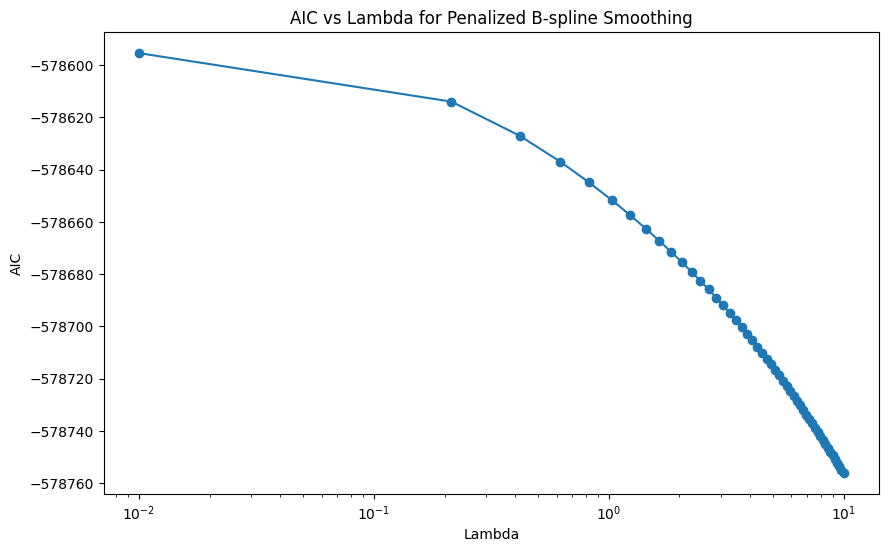

In [11]:
def calculate_aic(y, y_hat, smoother_matrix_trace):
    n = len(y)
    residual_sum_of_squares = np.sum((y - y_hat) ** 2)
    sigma_hat_squared = residual_sum_of_squares / n
    aic = n * np.log(sigma_hat_squared) + 2 * smoother_matrix_trace
    return aic

def find_optimal_lambda(df, x, y, num_knots, lambda_range):
    aic_values = []
    lambdas = []
    
    best_lambda = None
    best_aic = np.inf
    best_smoothed_values = None
    best_coefficients = None
    
    for lambda_penalty in lambda_range:
        smoothed_values, coefficients = pspline_penalized_smoothing(df, x, y, num_knots, lambda_penalty)
        
        # Assuming the smoother matrix trace is approximated by the number of non-zero coefficients
        smoother_matrix_trace = np.sum(coefficients != 0)
        aic = calculate_aic(df[y].values, smoothed_values, smoother_matrix_trace)
        
        aic_values.append(aic)
        lambdas.append(lambda_penalty)
        
        if aic < best_aic:
            best_aic = aic
            best_lambda = lambda_penalty
            best_smoothed_values = smoothed_values
            best_coefficients = coefficients
    
    return best_lambda, best_aic, best_smoothed_values, best_coefficients, aic_values, lambdas

# Example usage with a range of lambda values
lambda_range = np.linspace(0.01, 10, 50) 
num_knots = 12

# Assuming phylo DataFrame is already defined
optimal_lambda, optimal_aic, optimal_smoothed_values, optimal_coefficients, aic_values, lambdas = find_optimal_lambda(train_phylo, 'xcoord', 'normalised.largest.rtt', num_knots, lambda_range)

print(f"Optimal lambda: {optimal_lambda}")
print(f"Optimal AIC: {optimal_aic}")

# Plot AIC against lambda
plt.figure(figsize=(10, 6))
plt.plot(lambdas, aic_values, marker='o')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('AIC')
plt.title('AIC vs Lambda for Penalized B-spline Smoothing')
plt.show()

In [15]:
smoothed_lrtt_train, coefficients_lrtt_train = apply_pspline_smoothing(train_phylo, 'xcoord', 'normalised.largest.rtt', 12, lambda_penalty = 10)


/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_1043/4081157836.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  smoothed_values = df.groupby('RENAME_ID', group_keys=False).apply(
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_1043/4081157836.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  coefficients = df.groupby('RENAME_ID').apply(


/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_1043/1564647997.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_phylo['smoothed_lrtt'] = smoothed_lrtt_train
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_1043/1564647997.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = train_phylo.groupby(['TSI_category', 'xcoord']).agg({


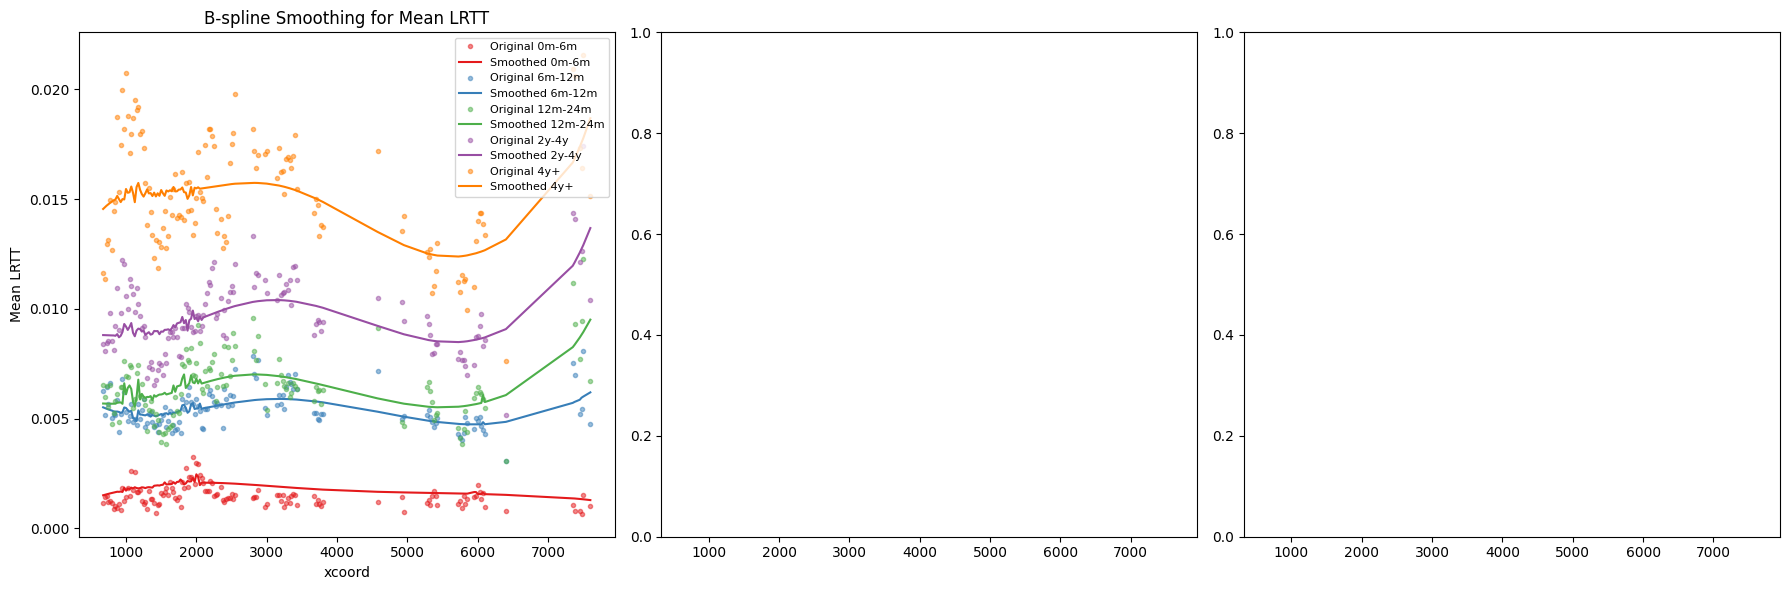

In [16]:
# Adding smoothed values to the DataFrame
train_phylo['smoothed_lrtt'] = smoothed_lrtt_train

mean_values = train_phylo.groupby(['TSI_category', 'xcoord']).agg({
    'normalised.largest.rtt': 'mean',
    'smoothed_lrtt': 'mean'
}).reset_index()

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
palette = sns.color_palette("Set1", n_colors=5)

# Plot for normalised.largest.rtt
for i, category in enumerate(mean_values['TSI_category'].unique()):
    category_df = mean_values[mean_values['TSI_category'] == category]
    axs[0].plot(category_df['xcoord'], category_df['normalised.largest.rtt'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
    axs[0].plot(category_df['xcoord'], category_df['smoothed_lrtt'], '-', label=f'Smoothed {category}', color=palette[i])

axs[0].set_xlabel('xcoord')
axs[0].set_ylabel('Mean LRTT')
axs[0].legend(loc='upper right', fontsize=8)
axs[0].set_title('B-spline Smoothing for Mean LRTT')

plt.tight_layout()
plt.show()

## with optimized lambda

In [29]:
lambda_penalty = 1.0

# Apply P-spline smoothing
smoothed_lrtt_train, coefficients_lrtt_train = apply_pspline_smoothing(train_phylo, 'xcoord', 'normalised.largest.rtt', 13, lambda_penalty)
smoothed_maf12c_train, coefficients_maf12c_train = apply_pspline_smoothing(train_maf, 'Window_Centre', 'MAF12c_Mean', 20, lambda_penalty)
smoothed_maf3c_train, coefficients_maf3c_train = apply_pspline_smoothing(train_maf, 'Window_Centre', 'MAF3c_Mean', 4, lambda_penalty)

smoothed_lrtt_test, coefficients_lrtt_test = apply_pspline_smoothing(test_phylo, 'xcoord', 'normalised.largest.rtt', 13, lambda_penalty)
smoothed_maf12c_test, coefficients_maf12c_test = apply_pspline_smoothing(test_maf, 'Window_Centre', 'MAF12c_Mean', 20, lambda_penalty)
smoothed_maf3c_test, coefficients_maf3c_test = apply_pspline_smoothing(test_maf, 'Window_Centre', 'MAF3c_Mean', 4, lambda_penalty)

# Adding smoothed values to the DataFrame
train_phylo['smoothed_lrtt'] = smoothed_lrtt_train
train_maf['smoothed_maf12c'] = smoothed_maf12c_train
train_maf['smoothed_maf3c'] = smoothed_maf3c_train

test_phylo['smoothed_lrtt'] = smoothed_lrtt_test
test_maf['smoothed_maf12c'] = smoothed_maf12c_test
test_maf['smoothed_maf3c'] = smoothed_maf3c_test

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_1043/1380565142.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  smoothed_values = df.groupby('RENAME_ID', group_keys=False).apply(
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_1043/1380565142.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  coefficients = df.groupby('RENAME_ID').apply(
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180

## Plot

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_1043/3034872832.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = train_phylo.groupby(['TSI_category', 'xcoord']).agg({
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_1043/3034872832.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values_maf = train_maf.groupby(['TSI_category', 'Window_Centre']).agg({


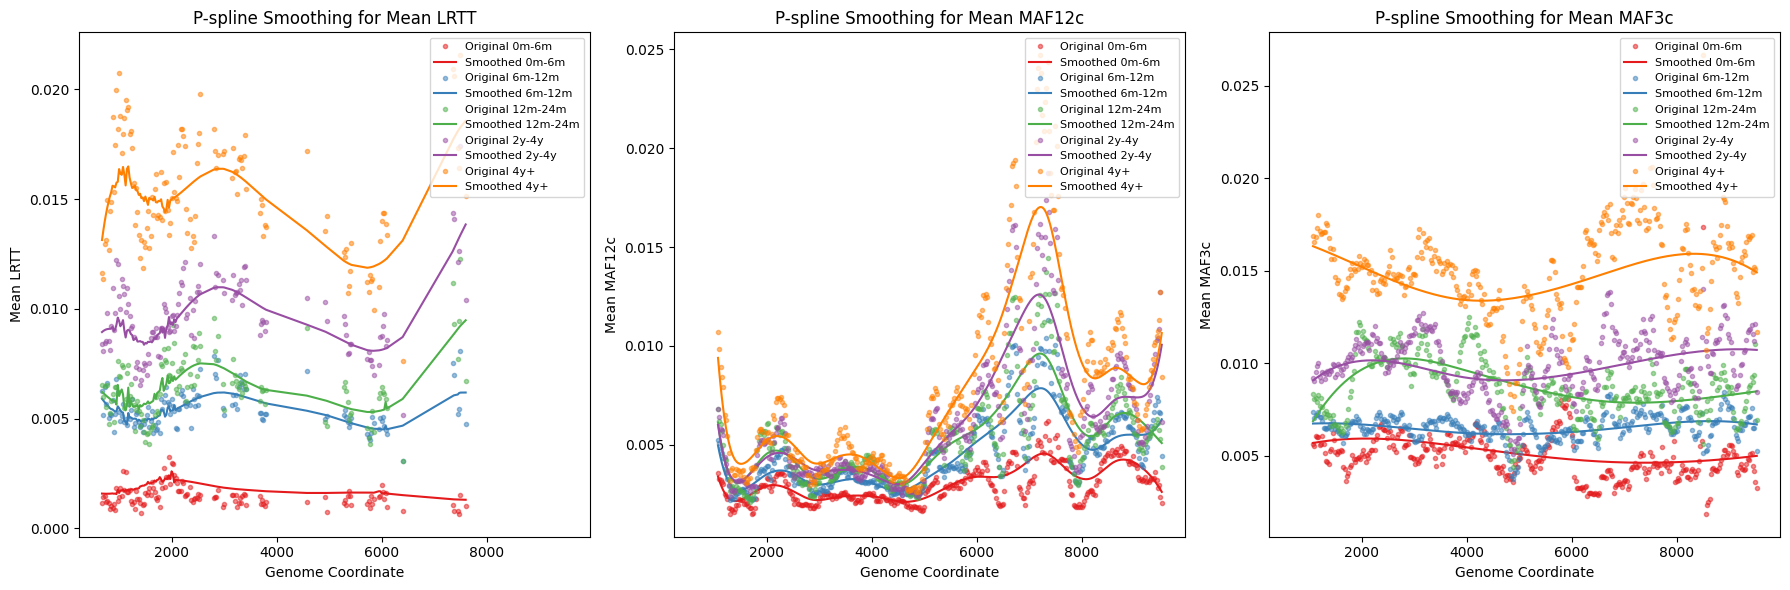

In [31]:
mean_values = train_phylo.groupby(['TSI_category', 'xcoord']).agg({
    'normalised.largest.rtt': 'mean',
    'smoothed_lrtt': 'mean'
}).reset_index()

mean_values_maf = train_maf.groupby(['TSI_category', 'Window_Centre']).agg({
    'MAF12c_Mean': 'mean',
    'smoothed_maf12c': 'mean',
    'MAF3c_Mean': 'mean',
    'smoothed_maf3c': 'mean'
}).reset_index()

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
palette = sns.color_palette("Set1", n_colors=5)

# Plot for normalised.largest.rtt
for i, category in enumerate(mean_values['TSI_category'].unique()):
    category_df = mean_values[mean_values['TSI_category'] == category]
    axs[0].plot(category_df['xcoord'], category_df['normalised.largest.rtt'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
    axs[0].plot(category_df['xcoord'], category_df['smoothed_lrtt'], '-', label=f'Smoothed {category}', color=palette[i])

axs[0].set_xlabel('Genome Coordinate')
axs[0].set_ylabel('Mean LRTT')
axs[0].legend(loc='upper right', fontsize=8)
axs[0].set_title('P-spline Smoothing for Mean LRTT')

# Plot for MAF12c_Mean
for i, category in enumerate(mean_values_maf['TSI_category'].unique()):
    category_df = mean_values_maf[mean_values_maf['TSI_category'] == category]
    axs[1].plot(category_df['Window_Centre'], category_df['MAF12c_Mean'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
    axs[1].plot(category_df['Window_Centre'], category_df['smoothed_maf12c'], '-', label=f'Smoothed {category}', color=palette[i])

axs[1].set_xlabel('Genome Coordinate')
axs[1].set_ylabel('Mean MAF12c')
axs[1].legend(loc='upper right', fontsize=8)
axs[1].set_title('P-spline Smoothing for Mean MAF12c')

# Plot for MAF3c_Mean
for i, category in enumerate(mean_values_maf['TSI_category'].unique()):
    category_df = mean_values_maf[mean_values_maf['TSI_category'] == category]
    axs[2].plot(category_df['Window_Centre'], category_df['MAF3c_Mean'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
    axs[2].plot(category_df['Window_Centre'], category_df['smoothed_maf3c'], '-', label=f'Smoothed {category}', color=palette[i])

axs[2].set_xlabel('Genome Coordinate')
axs[2].set_ylabel('Mean MAF3c')
axs[2].legend(loc='upper right', fontsize=8)
axs[2].set_title('P-spline Smoothing for Mean MAF3c')

plt.tight_layout()
plt.show()

## agreggating features

In [32]:
first_second_codon_pos, third_codon_pos, gag, pol, gp120, gp41 = load_reference_data2('./data/')

# Generate aggregated features for train and test datasets separately
train_phylo_features = generate_lrtt_features(train_phylo, gag, pol, gp120, gp41, feature='smoothed_lrtt')
test_phylo_features = generate_lrtt_features(test_phylo, gag, pol, gp120, gp41, feature='smoothed_lrtt')

train_maf_features = generate_maf_features(train_maf, gag, pol, gp120, gp41, feature_12c = 'smoothed_maf12c', feature_3c= 'smoothed_maf3c')
test_maf_features = generate_maf_features(test_maf, gag, pol, gp120, gp41, feature_12c = 'smoothed_maf12c', feature_3c= 'smoothed_maf3c')

# Merge the aggregated features
train_features = pd.merge(train_phylo_features, train_maf_features, on=['RENAME_ID', 'TSI_days'], how = 'inner')
test_features = pd.merge(test_phylo_features, test_maf_features, on=['RENAME_ID', 'TSI_days'], how = 'inner')

In [33]:
# Finalize the features
train_features = stratify5(train_features)
test_features = stratify5(test_features)

## Adding Meta Features: Coefficients

In [34]:
def expand_coefficients(df, coeffs, prefix):
    """
    Expand spline coefficients into the DataFrame as new features.

    Parameters:
    df : pandas.DataFrame
        DataFrame containing the original data.
    coeffs : pandas.DataFrame
        DataFrame containing the spline coefficients.
    prefix : str
        Prefix for the new coefficient columns.

    Returns:
    df : pandas.DataFrame
        DataFrame with the expanded coefficient features.
    """
    coeffs_df = coeffs.reset_index()
    coeffs_df.columns = [f'{prefix}_coeff_{col}' if col != 'RENAME_ID' else 'RENAME_ID' for col in coeffs_df.columns]
    coeffs_df = coeffs_df.iloc[:, :-4]  # Drop the last four columns
    return pd.merge(df, coeffs_df, on='RENAME_ID', how='left')

train_features = expand_coefficients(train_features, coefficients_lrtt_train, 'lrtt')
train_features = expand_coefficients(train_features, coefficients_maf12c_train, 'maf12c')
train_features = expand_coefficients(train_features, coefficients_maf3c_train, 'maf3c')

test_features = expand_coefficients(test_features, coefficients_lrtt_test, 'lrtt')
test_features = expand_coefficients(test_features, coefficients_maf12c_test, 'maf12c')
test_features = expand_coefficients(test_features, coefficients_maf3c_test, 'maf3c')

## Add Ambiguity Data

In [35]:
# Merge ambiguity data
train_features = pd.merge(train_features, train_ambig[['RENAME_ID', 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig']], on='RENAME_ID', how='inner')
test_features = pd.merge(test_features, test_ambig[['RENAME_ID', 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig']], on='RENAME_ID', how='inner')

In [36]:
train_features.to_csv('./data/derived/feature_selection/pspline_training_data.csv', header = True)
test_features.to_csv('./data/derived/feature_selection/pspline_test_data.csv', header = True)